# Building and training a Fruit classifier model

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, Dropout, Activation, Flatten, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow import keras
import sklearn
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
from os import listdir
from os.path import isfile, join
import re
import ntpath

print("Python modules imported")

Python modules imported


In [3]:
# Load images from folders

# treat as raw string
dataset_path = "..\\datasets\\fruits-360\\"

img_rows, img_cols = 32, 32

batch_size = 32

print(dataset_path)

# Load datasets, normalize, one hot-encode and do some data augmentaiton
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)
 
validation_datagen = ImageDataGenerator(
      rescale=1./255,      
      validation_split=0.2)
 
train_dataset = train_datagen.flow_from_directory(
        dataset_path + "train",
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset="training")
 
validation_dataset = validation_datagen.flow_from_directory(
        dataset_path + "train",
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        subset="validation")

# To display images
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "train",
    validation_split=0.2,
    subset="training",
    seed=200,
    shuffle=True,
    image_size=(100, 100),
    batch_size=batch_size
)

# loading test dataset
test_dataset = glob.glob(dataset_path + "test-multiple_fruits/*.jpg")


class_names = train_dataset.class_indices
# print("\n" + str(class_names))

class_list = list(class_names)
print("\n" + str(class_list))

num_of_classes = train_dataset.num_classes
print("\n" + str(num_of_classes))

image_shape = train_dataset.image_shape
print("\n" + str(image_shape))

print("\nNo of test images: " + str(len(test_dataset)))

print("\nTraining, validation and testing datasets now loaded and labels hot encoded")

..\datasets\fruits-360\
Found 33078 images belonging to 81 classes.
Found 8244 images belonging to 81 classes.
Found 41322 files belonging to 81 classes.
Using 33058 files for training.

['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', '

(32, 100, 100, 3)
(32,)


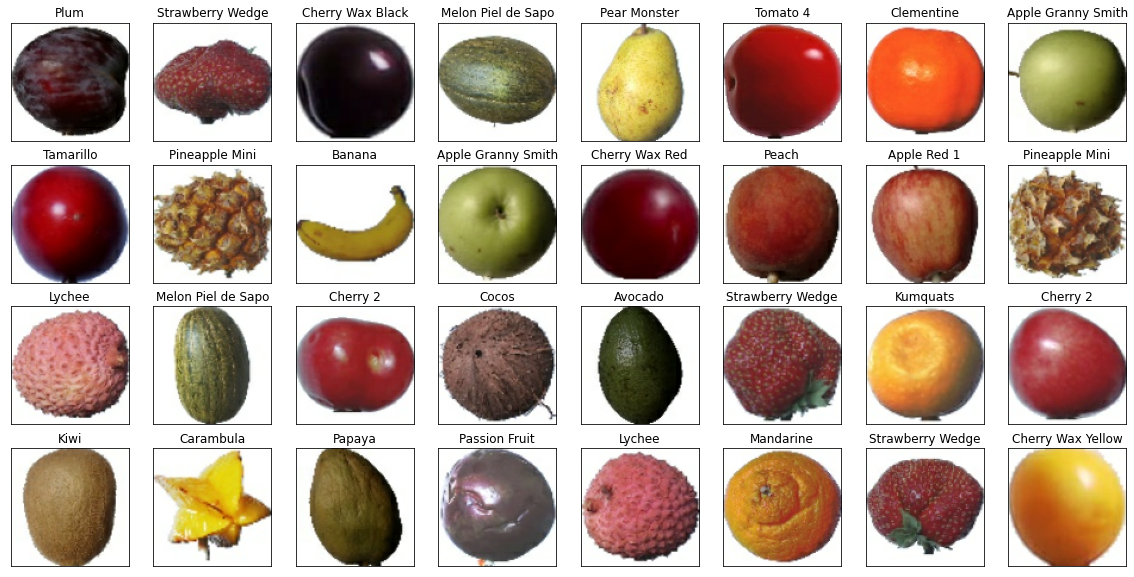

In [7]:
# visualize the training images

image_plot = plt.figure(figsize=(20, 10))
for images, labels in train_images.take(1):
    print(images.shape)
    print(labels.shape)
    for i in range(32):
        axis = image_plot.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        axis.imshow(images[i].numpy().astype("uint8"))
        axis.set_title(class_list[labels[i]])
        plt.savefig('random_img_in_dataset.jpg')

In [8]:
# build model architecture for training

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size =(3,3) , padding = 'same', input_shape = (img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size =(3,3) , padding = 'same'))
model.add(Activation("relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation("softmax"))


model.summary()
# saving model architechture to file for use some other time.

json_config = model.to_json()
model_config_file = open("fruit_classifier_cnn_config.json", "w")
model_config_file.write(json_config)
model_config_file.close()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [9]:
# save model at intervals
checkpoint = ModelCheckpoint(filepath="fruits_class_cnn_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

# Stop training the model when the loss has stop reducing, monitor loses.
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# reduce learning rate when loss metric has stoped increasing
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

epochs = 10

history = model.fit(
    train_dataset,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = callbacks,
    verbose = 1,
    validation_data = validation_dataset)

Epoch 1/10
1034/1034 [==============================] - ETA: 0s - loss: 2.3487 - accuracy: 0.3201
Epoch 00001: val_loss improved from inf to 0.96307, saving model to fruits_class_cnn_1.h5
1034/1034 [==============================] - 1036s 1s/step - loss: 2.3487 - accuracy: 0.3201 - val_loss: 0.9631 - val_accuracy: 0.7040
Epoch 2/10
1034/1034 [==============================] - ETA: 0s - loss: 0.8882 - accuracy: 0.7064
Epoch 00002: val_loss improved from 0.96307 to 0.38761, saving model to fruits_class_cnn_1.h5
1034/1034 [==============================] - 194s 188ms/step - loss: 0.8882 - accuracy: 0.7064 - val_loss: 0.3876 - val_accuracy: 0.8721
Epoch 3/10
1034/1034 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.8172
Epoch 00003: val_loss improved from 0.38761 to 0.29828, saving model to fruits_class_cnn_1.h5
1034/1034 [==============================] - 207s 200ms/step - loss: 0.5539 - accuracy: 0.8172 - val_loss: 0.2983 - val_accuracy: 0.9195
Epoch 4/10
1034/103

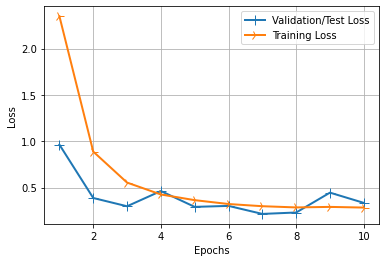

In [10]:
# Training / Validation Loss chart

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('loss_chart.jpg')
plt.show()

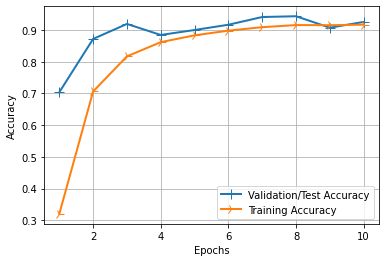

In [17]:
# Training / Validation Accuracy chart

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('accuracy_chart.jpg')
plt.show()

In [12]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("fruit_360_classifier_model")
print("Model saved")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: fruit_360_classifier_model\assets
Model saved


In [13]:
#Confution Matrix and Classification Report on trained model

class_labels = validation_dataset.class_indices
class_labels = {v: k for k, v in class_labels.items()}

# nb_train_samples = 33078
nb_validation_samples = 8244

Y_pred = model.predict(validation_dataset, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

print('Confusion Matrix')
print(confusion_matrix(validation_dataset.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_dataset.classes, y_pred, target_names=target_names))



Confusion Matrix
[[ 89   0   0 ...   0   0   0]
 [  0  91   1 ...   0   0   0]
 [  0   0  98 ...   0   0   0]
 ...
 [  0   0   0 ...  98   0   0]
 [  0   0   0 ...   0  73   0]
 [  0   0   0 ...   0   0 147]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.49      0.91      0.63        98
     Apple Golden 1       0.71      0.93      0.80        98
     Apple Golden 2       0.99      1.00      0.99        98
     Apple Golden 3       1.00      0.93      0.96        96
 Apple Granny Smith       0.51      1.00      0.68        98
        Apple Red 1       1.00      1.00      1.00        98
        Apple Red 2       1.00      0.38      0.55        98
        Apple Red 3       1.00      1.00      1.00        85
Apple Red Delicious       1.00      1.00      1.00        98
   Apple Red Yellow       1.00      0.61      0.76        98
            Apricot       1.00      1.00      1.00        98
            Avocado       1.00      

In [4]:
classifier = load_model('fruit_360_classifier_model')

print("model loaded")

model loaded


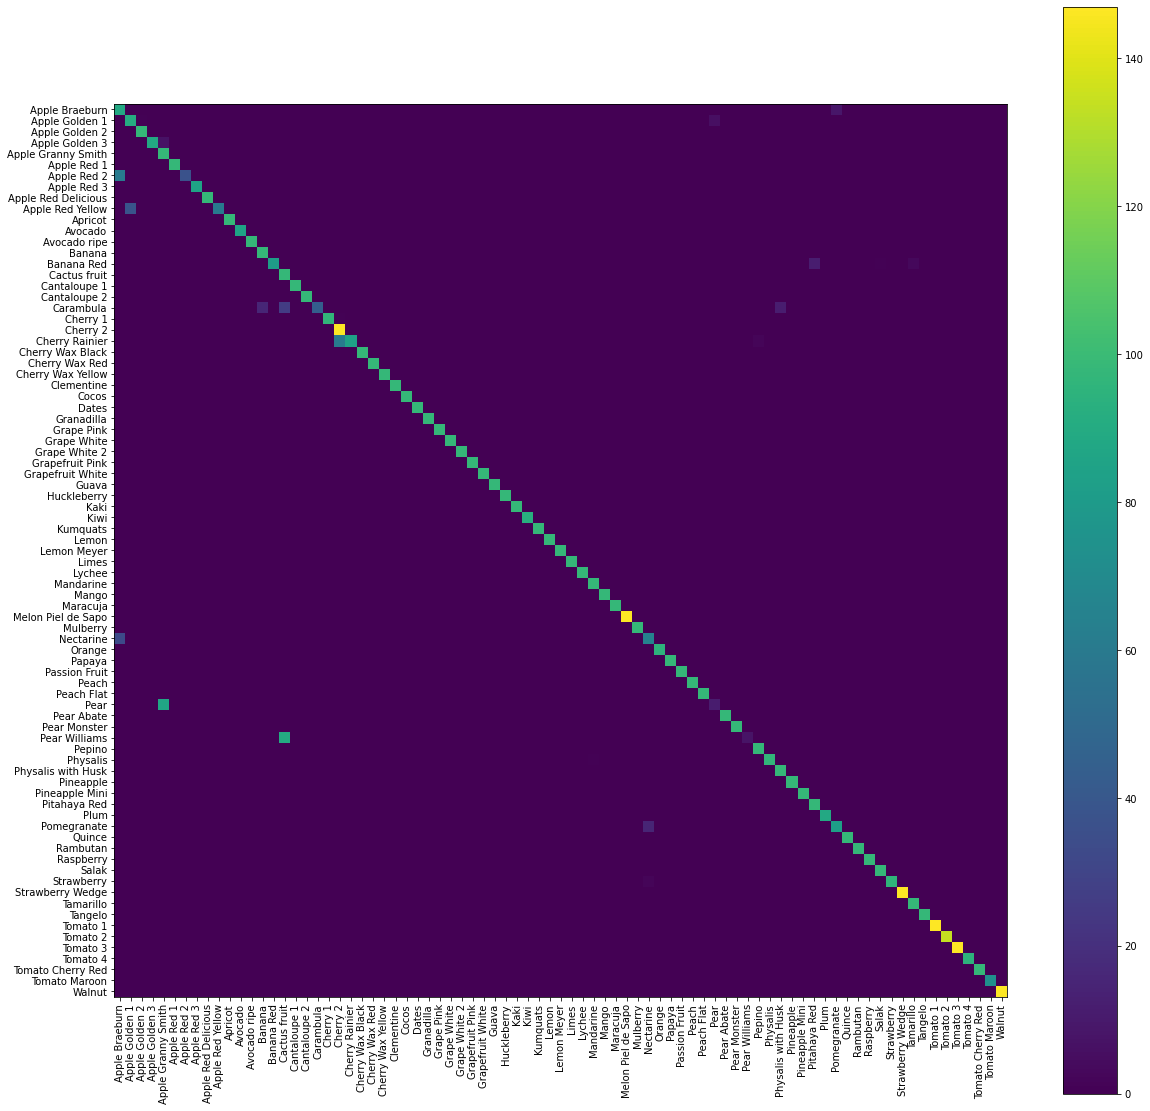

In [18]:
#Confution Matrix and Classification Report on loaded model

Y_predict = classifier.predict(validation_dataset, nb_validation_samples // batch_size+1)
y_predict = np.argmax(Y_predict, axis=1)
classes = list(class_names)

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_dataset.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
_ = plt.savefig('confution_matrix.jpg')

### Testing trained fruit classifier model

In [14]:
# draw prediction and true texts

from tensorflow.keras.preprocessing import image

class_labels = validation_dataset.class_indices
class_labels = {v: k for k, v in class_labels.items()}

def draw_text(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)
    cv2.imwrite(name+".jpg", expanded_image)

# get random images from validation folder
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "\\" + image_name
    # print(final_path)
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class


files = []
predictions = []
true_labels = []


# predicting 15 images classes
for i in range(0, 10):
    path = dataset_path + 'validation\\' 
    img, final_path, true_label = getRandomImage(path, img_rows, img_cols)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_text("Prediction" + str(i+11), class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()